In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as mpl

In [2]:
df = pd.read_excel('./data/in/RomerandRomerDataAppendix.xls',sheet_name='DATA BY MONTH',index_col=0)
df

,RESID,DFF,DTARG,RESIDF,PCIPNSA,PCWCP,PCPPINSA,PCCPINSA,PCPCEGSA,LNIPNSA,LNPPINSA,LNWCP,SUMSHCK,FF,SUMDTARG,SUMSHCKF
DATE,,,,,,,,,,,,,,,,
1966-01-01,0.000000,NaN,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,3.703990,3.549617,3.453474,0.000000e+00,4.42,0.0000,0.000000
1966-02-01,0.000000,0.18,0.0,0.000000,0.027662,0.016317,0.005731,0.002963,0.004159,3.731652,3.555348,3.469790,0.000000e+00,4.60,0.0000,0.000000
1966-03-01,0.000000,0.05,0.0,0.000000,0.019874,0.008060,0.000000,0.005900,0.002451,3.751526,3.555348,3.477850,0.000000e+00,4.65,0.0000,0.000000
1966-04-01,0.000000,0.02,0.0,0.000000,-0.001575,0.000926,0.000000,0.005865,0.003377,3.749951,3.555348,3.478776,0.000000e+00,4.67,0.0000,0.000000
1966-05-01,0.000000,0.23,0.0,0.000000,0.007054,-0.014290,0.000000,0.000000,0.001197,3.757005,3.555348,3.464485,0.000000e+00,4.90,0.0000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996-08-01,-0.065340,-0.18,0.0,-0.182795,0.047797,0.001733,0.003037,0.000654,0.000940,4.557491,4.882044,4.587006,2.396496e-02,5.22,-3.3125,0.014031
1996-09-01,-0.042441,0.08,0.0,0.027880,0.014515,-0.017463,-0.000758,0.005869,0.002580,4.572006,4.881286,4.569543,-1.847630e-02,5.30,-3.3125,0.041911
1996-10-01,0.000000,-0.06,0.0,0.000000,-0.012074,-0.023911,0.006805,0.002597,0.002860,4.559932,4.888091,4.545632,-1.847630e-02,5.24,-3.3125,0.041911


In [3]:
def get_B_S(y,x,nLx,nLy,monthly_dummies=True):
    
    n1 = y.shape[0]
    nL = max(nLy,nLx)
    nT = n1 - nL

    Y = y.values.reshape(1,-1)

    if monthly_dummies:
        Z = pd.get_dummies(y.index.month).values.T
    else:
        Z = np.ones((1,n1))
    nZ,_ = Z.shape

    X = np.full((0,n1),np.nan)
    for h in range(1,nLy+1):
        X = np.row_stack((X,y.shift(h).T))
    for h in range(1,nLx+1):
        X = np.row_stack((X,x.shift(h).T))

    Y = Y[:,nL:]
    Z = Z[:,nL:]
    X = X[:,nL:]

    Mz = (np.eye(nT)-Z.T@np.linalg.inv(Z@Z.T)@Z)

    B = (Y@Mz@X.T)@np.linalg.inv(X@Mz@X.T)
    S = 1/(nT-nLx-nLy-nZ)*((Y-B@X)@Mz@(Y.T-X.T@B.T))*np.linalg.inv(X@Mz@X.T)
    
    return B,S

In [4]:
def get_irf(b,c,nLx,nLy,nH):
    irf = np.full(nH+1,np.nan)
    cc = np.pad(c,(0,nH-nLx+1))
    bb = np.pad(b,(0,nH-nLy+1))
    irf[0] = 0
    for h in range(1,nH+1):
        irf[h] = cc[h-1] + irf[:h][::-1]@bb[:h]
    return irf, np.cumsum(irf)

In [5]:
nLy = 24
nLx = 36
nH = 48
y = 100*df.loc[:,'PCIPNSA'].loc['1967':'1996']
x = df.loc[:,'RESID'].loc['1967':'1996']

In [6]:
B,S = get_B_S(y,x,nLx,nLy)

In [7]:
B = B[0]
b, c = B[:nLy], B[nLy:]

In [8]:
b.round(3)

array([ 0.063, -0.013,  0.107,  0.048,  0.028, -0.005,  0.018,  0.008,
        0.04 , -0.043,  0.071,  0.287,  0.023, -0.196, -0.151, -0.128,
        0.078,  0.085,  0.056,  0.081, -0.06 , -0.017, -0.068,  0.086])

In [9]:
c.round(4)

array([ 0.3785,  0.2618, -0.3802, -0.1172, -0.3932, -0.0062, -0.0815,
       -0.287 , -0.2105, -0.4689, -0.2544, -0.3545, -0.212 , -0.0697,
       -0.0306,  0.1871, -0.0917, -0.2443, -0.2264, -0.066 , -0.1084,
       -0.3239,  0.1457, -0.0034, -0.0108, -0.0015, -0.068 ,  0.3804,
        0.1287,  0.3497,  0.175 ,  0.0934,  0.1444,  0.4665,  0.1116,
        0.2373])

In [10]:
IRF_IP, CIRF_IP = get_irf(b,c,nLx,nLy,nH)
nR = 500
IRF_R = np.full((nR,nH+1),np.nan)
CIRF_R = np.full((nR,nH+1),np.nan)
for r in range(nR):
    B_r = np.random.multivariate_normal(B,S)
    b_r, c_r = B_r[:nLy], B_r[nLy:]
    irf_r, cirf_r = get_irf(b_r,c_r,nLx,nLy,nH)
    IRF_R[r], CIRF_R[r] = irf_r, cirf_r
CSTD_IP = CIRF_R.std(axis=0)
CIRF_IP_16, CIRF_IP_84 = CIRF_IP-CSTD_IP, CIRF_IP+CSTD_IP

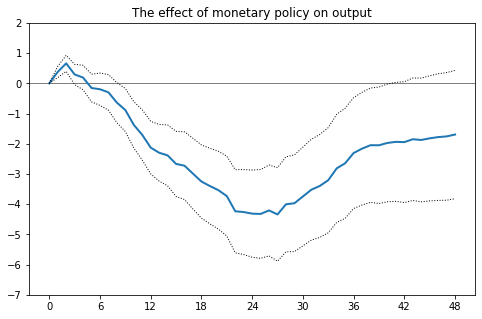

In [11]:
fig, ax = mpl.subplots(1,1,figsize=(8,5))
ax.plot(CIRF_IP,lw=2)
ax.plot(CIRF_IP_16,lw=1,color='k',ls=':')
ax.plot(CIRF_IP_84,lw=1,color='k',ls=':')
ax.axhline(y=0,color='k',lw=0.5,zorder=1)
ax.set_xticks(range(0,nH+1,6))
ax.set_yticks(np.arange(-7,2+1,1))
ax.set_ylim(-7,2)
ax.set_title('The effect of monetary policy on output');

### Prices

In [12]:
nLy = 24
nLx = 48
nH = 48
y = 100*df.loc[:,'PCPPINSA'].loc['1966':'1996']
x = df.loc[:,'RESID'].loc['1966':'1996']

In [13]:
B,S = get_B_S(y,x,nLx,nLy)

In [14]:
B = B[0]
b, c = B[:nLy], B[nLy:]

In [15]:
b.round(3)

array([ 0.192,  0.002, -0.038, -0.098,  0.009,  0.107, -0.056,  0.05 ,
        0.074, -0.049,  0.087,  0.127, -0.071, -0.02 , -0.019, -0.018,
        0.056,  0.029,  0.009,  0.093,  0.004, -0.004, -0.057,  0.045])

In [16]:
c.round(4)

array([ 0.0573,  0.0093, -0.0541,  0.1   ,  0.1449, -0.0563,  0.0079,
        0.0489, -0.1277,  0.0869, -0.1563, -0.029 ,  0.0126, -0.0225,
        0.0976, -0.0425,  0.0326, -0.1216,  0.0487, -0.1976,  0.0221,
       -0.0072, -0.1325, -0.1864, -0.2395, -0.2502, -0.1699, -0.0185,
       -0.219 , -0.3289, -0.3096, -0.0638, -0.1342, -0.0982, -0.152 ,
       -0.3346, -0.1879, -0.1551,  0.0099, -0.1691, -0.0662, -0.2926,
       -0.1315, -0.0272, -0.1482,  0.0089, -0.1512, -0.0768])

In [17]:
IRF_PPI, CIRF_PPI = get_irf(b,c,nLx,nLy,nH)
nR = 100
IRF_R = np.full((nR,nH+1),np.nan)
CIRF_R = np.full((nR,nH+1),np.nan)
for r in range(nR):
    B_r = np.random.multivariate_normal(B,S)
    b_r, c_r = B_r[:nLy], B_r[nLy:]
    irf_r, cirf_r = get_irf(b_r,c_r,nLx,nLy,nH)
    IRF_R[r], CIRF_R[r] = irf_r, cirf_r
CSTD_PPI = CIRF_R.std(axis=0)
CIRF_PPI_16, CIRF_PPI_84 = CIRF_PPI-CSTD_PPI, CIRF_PPI+CSTD_PPI

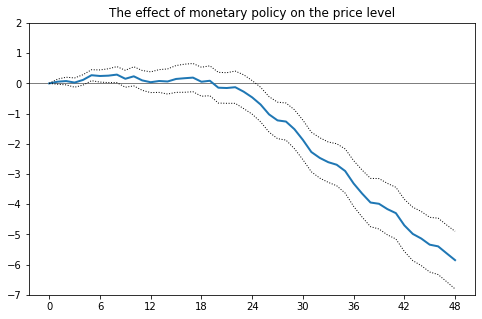

In [18]:
fig, ax = mpl.subplots(1,1,figsize=(8,5))
ax.plot(CIRF_PPI,lw=2)
ax.plot(CIRF_PPI_16,lw=1,color='k',ls=':')
ax.plot(CIRF_PPI_84,lw=1,color='k',ls=':')
ax.axhline(y=0,color='k',lw=0.5,zorder=1)
ax.set_xticks(range(0,nH+1,6))
ax.set_yticks(np.arange(-7,2+1,1))
ax.set_ylim(-7,2)
ax.set_title('The effect of monetary policy on the price level');